In [5]:
PROC_TRAIN_DATA_PATH = "../../data/interim/1__analytics_preprocessed_data.pkl"
FIG_DIR = "../../reports/figures/"

# Import packages

In [6]:
from typing import Any, Callable
from functools import wraps

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats


# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff

# from scipy import stats

import warnings
warnings.filterwarnings('ignore')


# from sklearn.preprocessing import MultiLabelBinarizer, Normalizer

In [7]:
# Change some pandas display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.width", 1000)
pd.set_option("styler.format.precision", 10)

# Data reading

In [8]:
df_train = pd.read_pickle(PROC_TRAIN_DATA_PATH)

In [9]:
# Obtain cat and num columns
cat_cols = df_train.select_dtypes("object").columns.to_list()
num_cols = df_train.select_dtypes(np.number).columns.to_list()

In [10]:
# Show a small batch of data
df_train.head()

,age,sex,chest pain type,resting blood pressure,serum cholestoral,fasting blood sugar,resting electrocardiographic,maximum heart rate,exercise induced angina,ST depression,slope peak exercise ST segment,number of major vessels,thallium stress result,target,age_encoded
155,51.0,male,asymptomatic,140.0,299.0,> 120 mg/dl,normal,173.0,yes,1.6,upsloping,0.0,reversible defect,LAD,Middle-Aged
10,56.0,female,atypical angina,140.0,294.0,> 120 mg/dl,ventricular hypertrophy,153.0,no,1.3,flat,0.0,normal,no disease,Senior
53,60.0,male,asymptomatic,130.0,253.0,> 120 mg/dl,normal,144.0,yes,1.4,upsloping,1.0,reversible defect,LAD,Senior
122,55.0,male,asymptomatic,140.0,217.0,> 120 mg/dl,normal,111.0,yes,5.6,downsloping,0.0,reversible defect,RCA,Middle-Aged
208,62.0,female,asymptomatic,150.0,244.0,> 120 mg/dl,normal,154.0,yes,1.4,flat,0.0,normal,LAD,Senior


# Statistical analysis

In [11]:
# Categorical features
df_train.describe(include="object").T

,count,unique,top,freq
sex,271,2,male,181
chest pain type,271,4,asymptomatic,128
fasting blood sugar,271,2,> 120 mg/dl,233
resting electrocardiographic,271,3,normal,138
exercise induced angina,271,2,no,181
slope peak exercise ST segment,271,3,flat,129
number of major vessels,267.0,4.0,0.0,155.0
thallium stress result,271,4,normal,150
target,271,5,no disease,146
age_encoded,270,3,Senior,134


# Balancing
Check if the training data is well balanced because one of the major issues when dealing with unbalanced datasets relates to the metrics used to evaluate a model. Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

In [13]:
def check_balancing(data, target):
    """
    Check if the target's classes are balanced between each other
    """
    # Target Class count
    figure = plt.figure(figsize=(8, 8))
    ax = figure.add_subplot(1, 1, 1)
    ax.pie(
        data[target].value_counts(),
        labels=data[target].unique(),
        autopct="%1.2f%%",
        explode=[0, 0.2, 0.2, 0.2, 0.2],
        shadow=True,
    )

    my_circle = plt.Circle((0, 0), 0.4, color="white")
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    ax.set_title("Target Classes percentage")
    figure.savefig(FIG_DIR + "target/values_percentage.jpg")

    check_balancing(data=df_train, target="target")

# Plotting

## Categorical features
The conclusions is the following features play good role to identify presence or absence of the disease:
- **slope peak exercise ST segment** 
- **exercise induced angina** 
- **chest pain type**
- **sex**


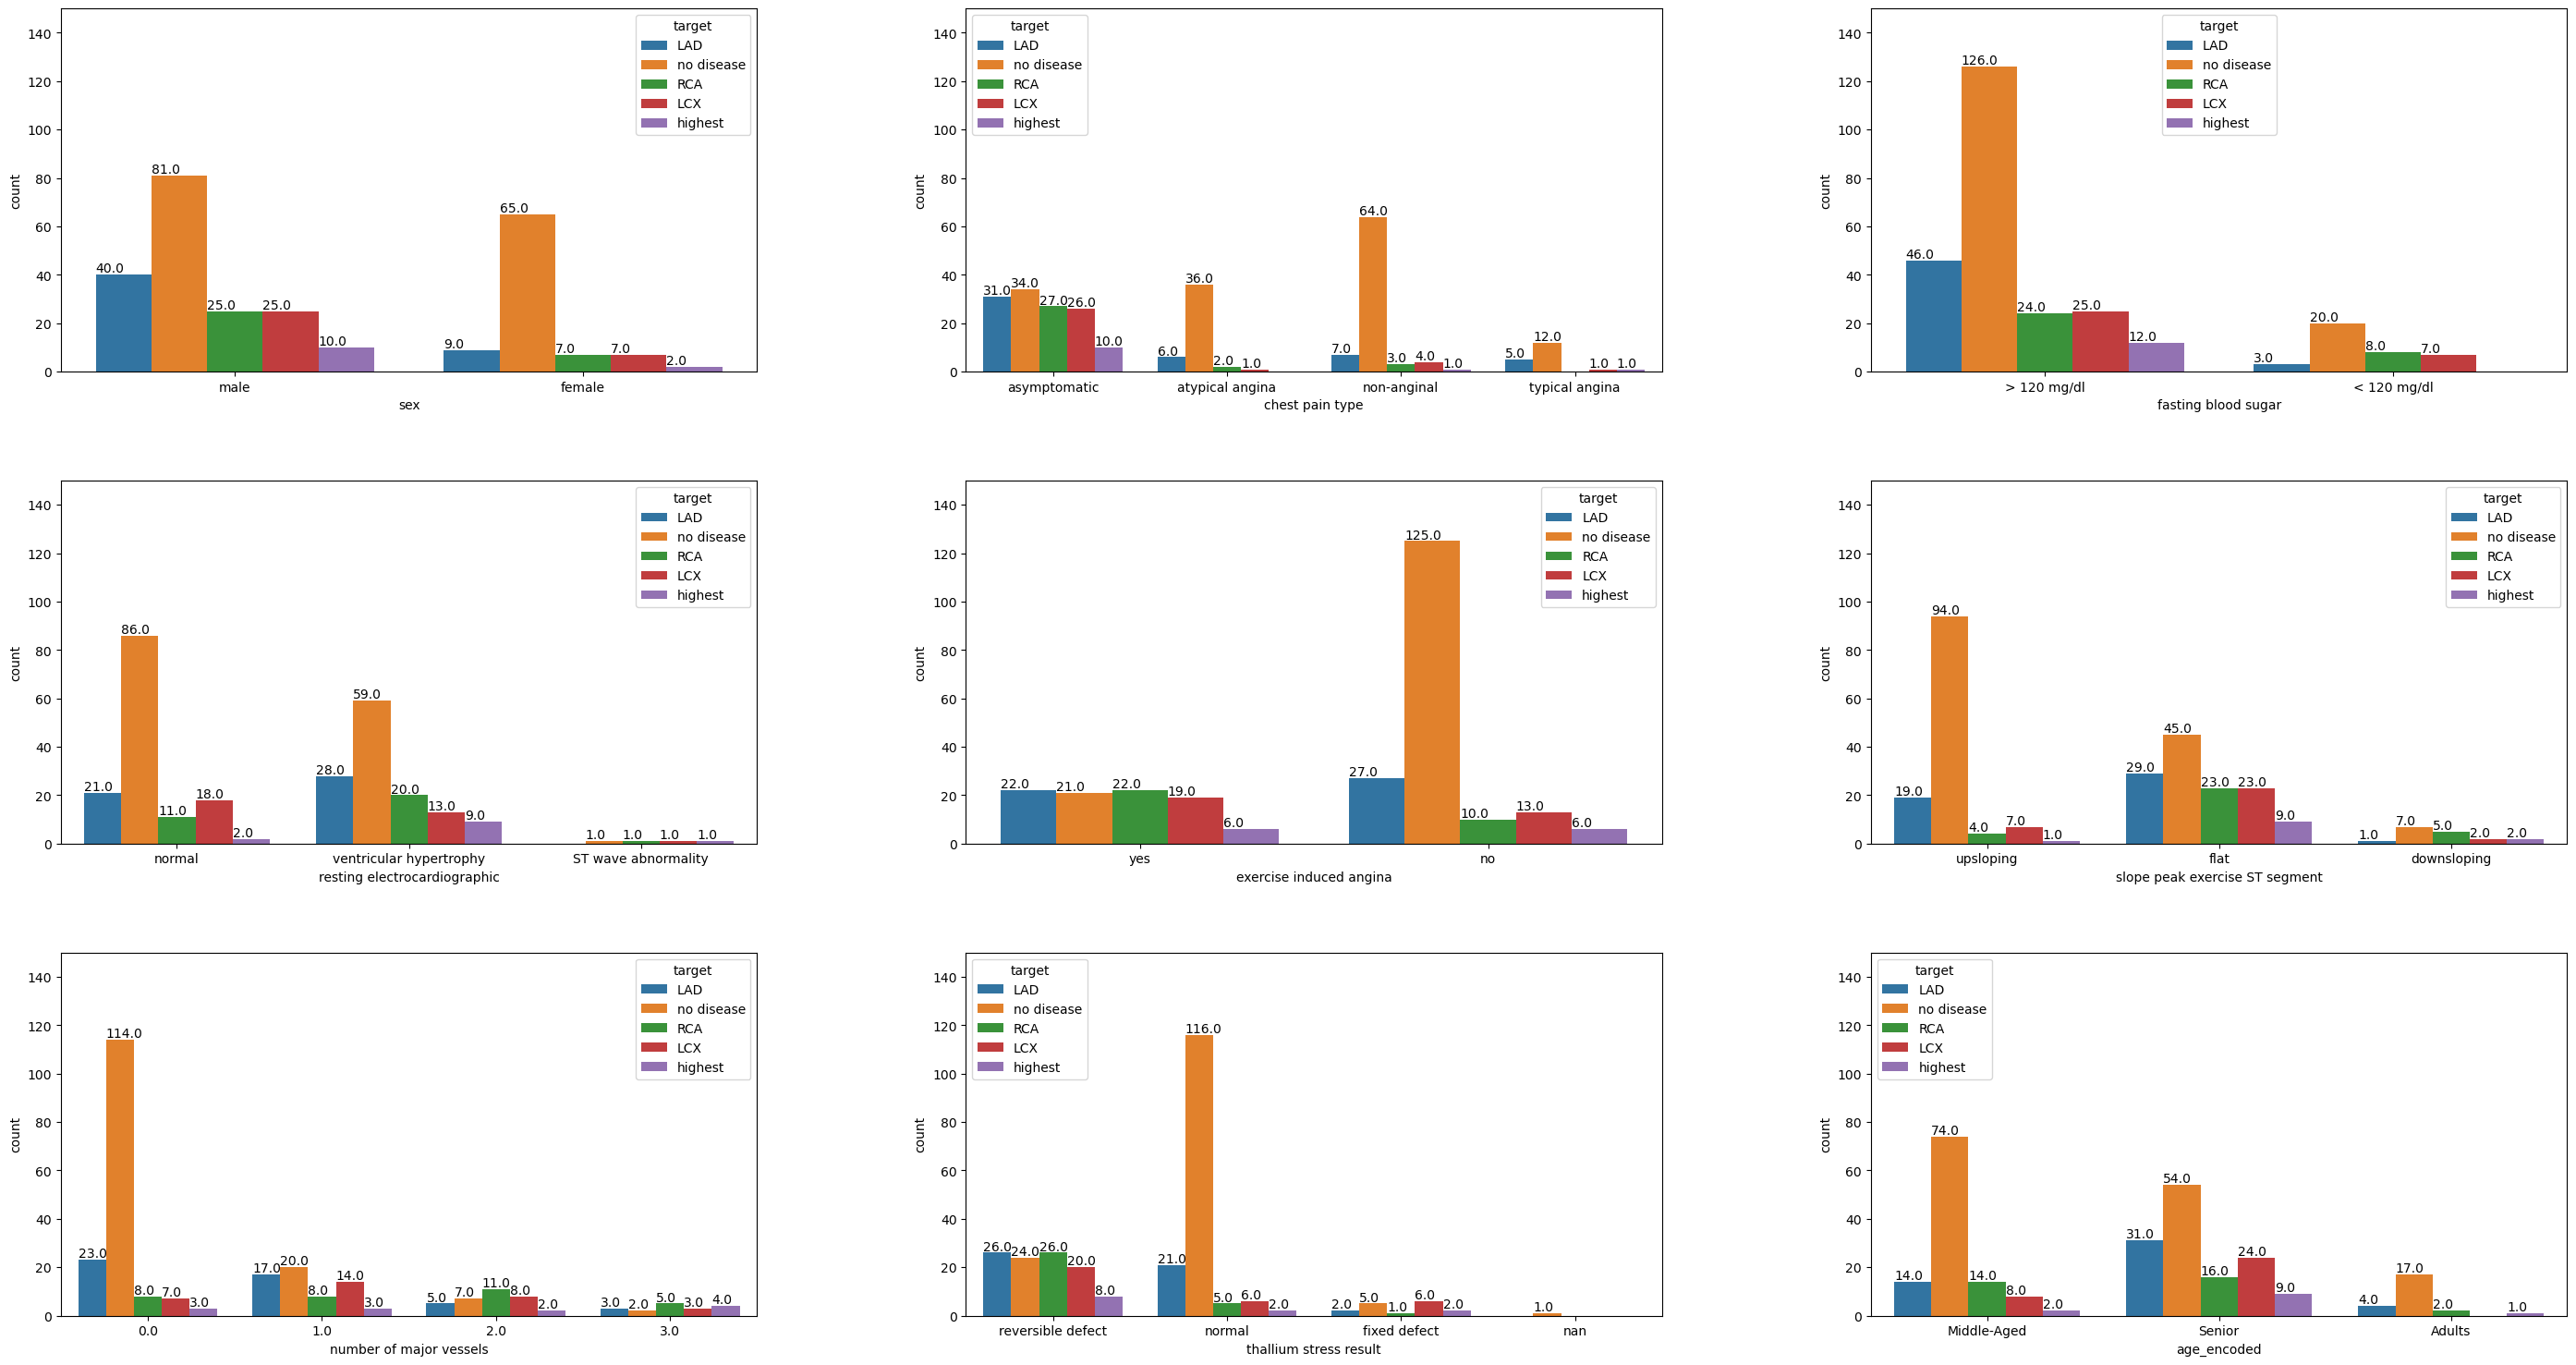

In [14]:
def parse_plot_cat(func: Callable[..., Any]):
    @wraps(func)
    def wrapper(*args, **kwargs):
        data = kwargs["data"]
        hue = kwargs["hue"]

        # Exclude hue (target) variable from columns
        cols = data.columns[data.columns != hue]

        figure = plt.figure(figsize=(35, 25))
        figure.subplots_adjust(wspace=0.3, hspace=0.3)

        for i, col in enumerate(cols, start=1):
            ax = figure.add_subplot(4, 3, i)
            graph = func(*args, **kwargs, x=col, ax=ax)
            for p in graph.patches:
                graph.annotate(f"{p.get_height():.1f}", (p.get_x(), p.get_height() + 1))
            graph.set_ylim([0, 150])
        figure.savefig(FIG_DIR + "categorical_features/count_plots.jpg")

    return wrapper


@parse_plot_cat
def plot_cat_var(
    data: pd.DataFrame,
    x: str = None,
    hue: str = None,
    ax: plt.Axes = None,
    palette: str = None,
) -> plt.Figure:
    """Plot the categorical features in respect for hue value

    Args:
        data (pd.DataFrame): train data
        x (str, optional): the feature to be plotted. Defaults to None.
        hue (str, optional): hue value. Defaults to None.
        ax (plt.Axes, optional): axes to put plot in it. Defaults to None.
        palette (str, optional): plot color type. Defaults to None.

    Returns:
        plt.Figure: figure contains all the plotted features
    """
    graph = sns.countplot(data=data, x=x, hue=hue, ax=ax, palette=palette)
    return graph


plot_cat_var(data=df_train[cat_cols], hue="target")

## Numerical data
The conclusions is the following features play good role to identify presence or absence of the disease:
- **max heart rate** 
- **age** 
- **ST depression**


### Histogram - Probability
*Observations* :
- **ST Depression** & **Number of major Vessels** is Right Skewed.<br>
- **Age** & **Resting Blood Pressure** & **Maximum Heart Rate** are close to Normal / Gaussian Distribution.

- **Risk** is increasing gradually with the age. 
- **Resting Blood Pressure** is noticeably increasing when the risk of heart disease is high.


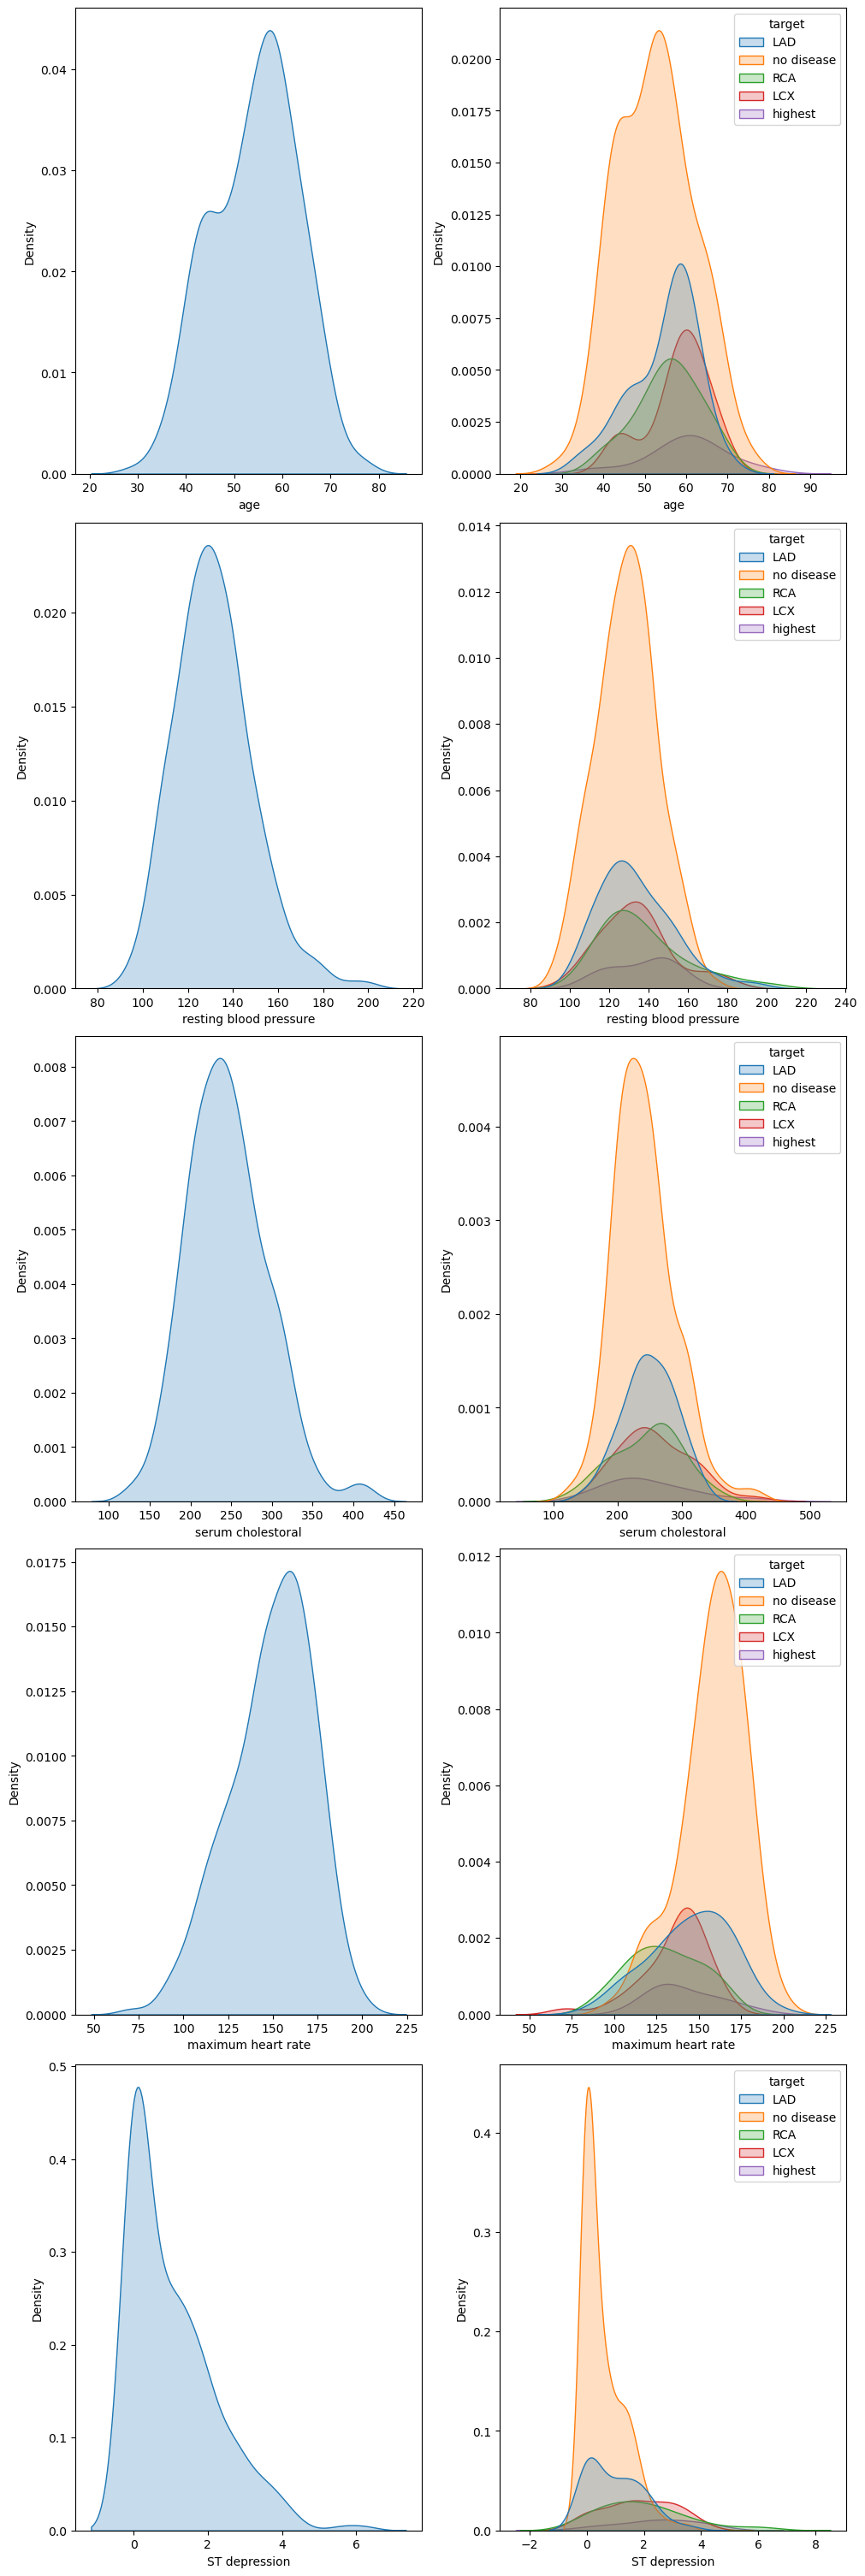

In [15]:
def plot_kde(data: pd.DataFrame, hue: str):
    cols = data.columns[data.columns != hue]
    sub_num_of_row = len(cols)
    sub_num_of_col = 2

    _, axs = plt.subplots(
        nrows=sub_num_of_row,
        ncols=sub_num_of_col,
        figsize=(10, 30),
        constrained_layout=True,
    )

    for i in range(sub_num_of_row):
        # stats.probplot(x= data[cols[i]], plot=axs[i][0], rvalue=True)
        sns.kdeplot(data=data, x=cols[i], fill=True, ax=axs[i][0])
        sns.kdeplot(data=data, x=cols[i], hue=hue, fill=True, ax=axs[i][1])


plot_kde(data=df_train[num_cols + ["target"]], hue="target")

#### Bar

In [16]:
# df_train.groupby(['target', 'age_encoded'])['age_encoded'].count().to_frame().unstack().plot(kind='bar', stacked=False, figsize=(10,10))

#### Box
*Observations*:
- **resting blood pressure** & **serum cholestoral** are increasing by age group and gender.
- **maximum heart rate** is decreasing by age group and gender.


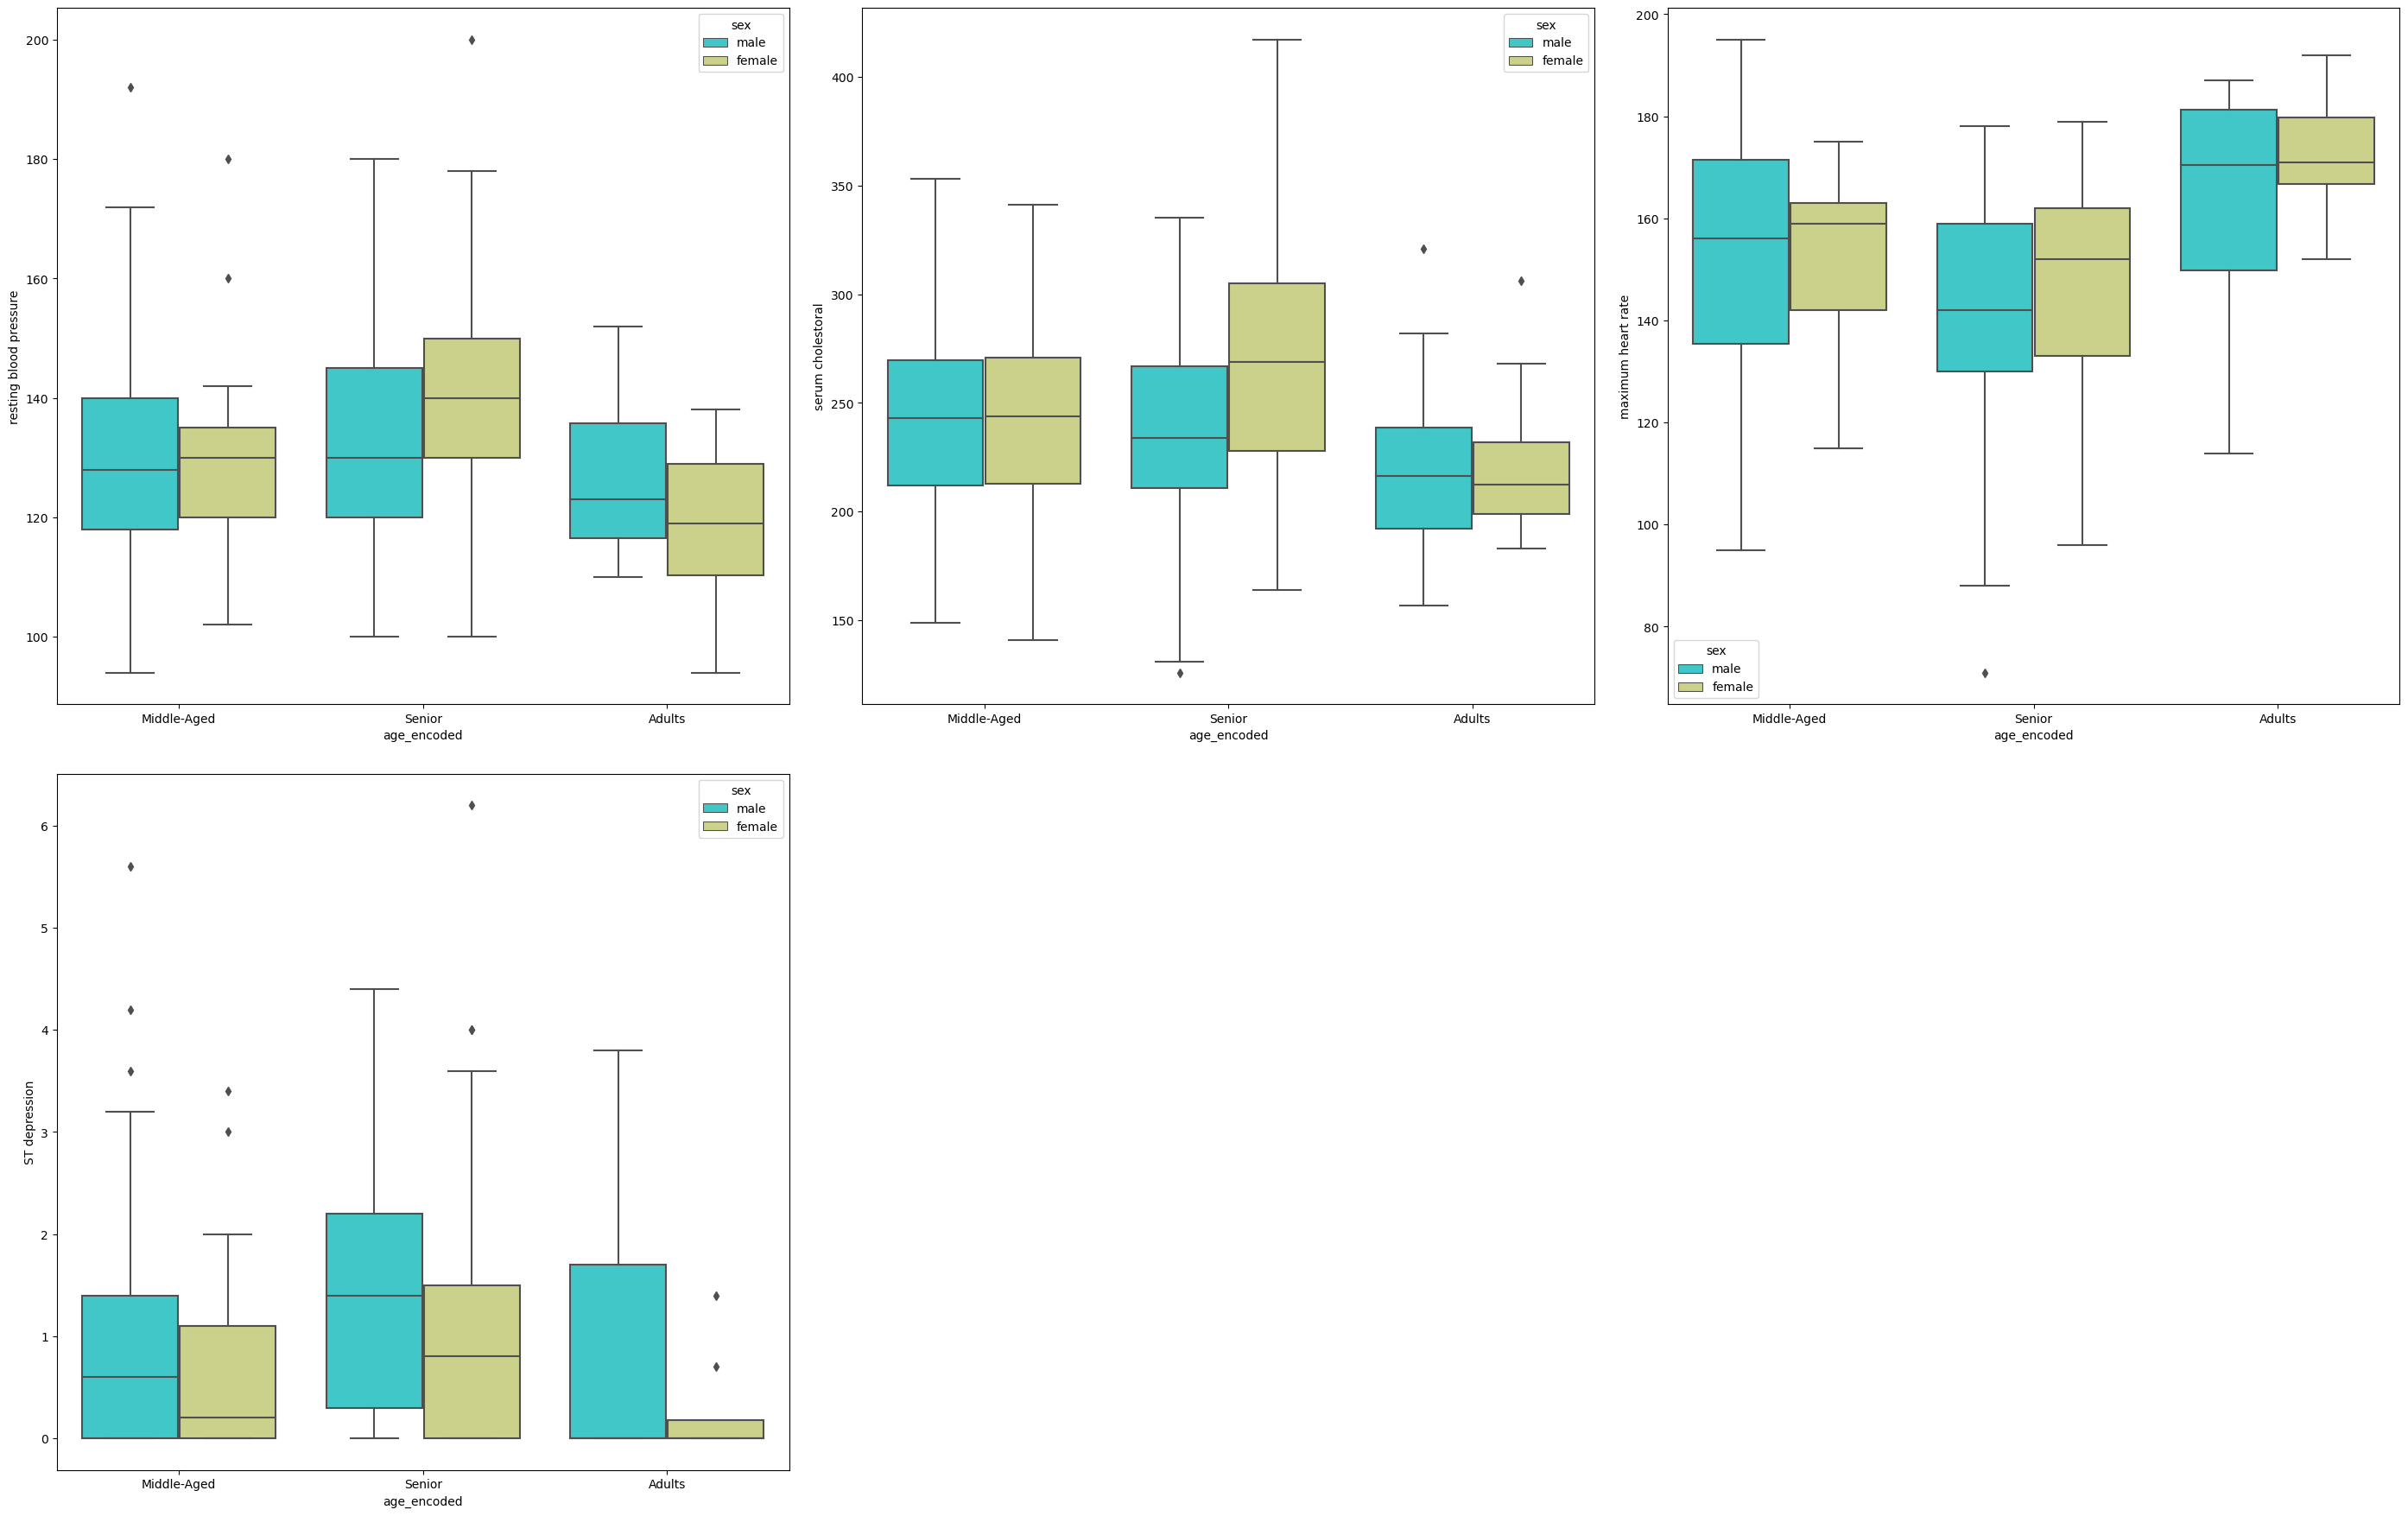

In [17]:
def plot_boxen(data):
    cols = list(
        filter(
            lambda x: x not in cat_cols + ["age", "target", "age_encoded"],
            data.columns.to_list(),
        )
    )

    figure = plt.figure(figsize=(35, 45))
    figure.subplots_adjust(wspace=0.1, hspace=0.1)

    for i, col in enumerate(cols, start=1):
        ax = figure.add_subplot(4, 3, i)
        sns.boxplot(
            x="age_encoded", y=col, hue="sex", data=data, palette="rainbow", ax=ax
        )


plot_boxen(df_train)

#### Pairplot

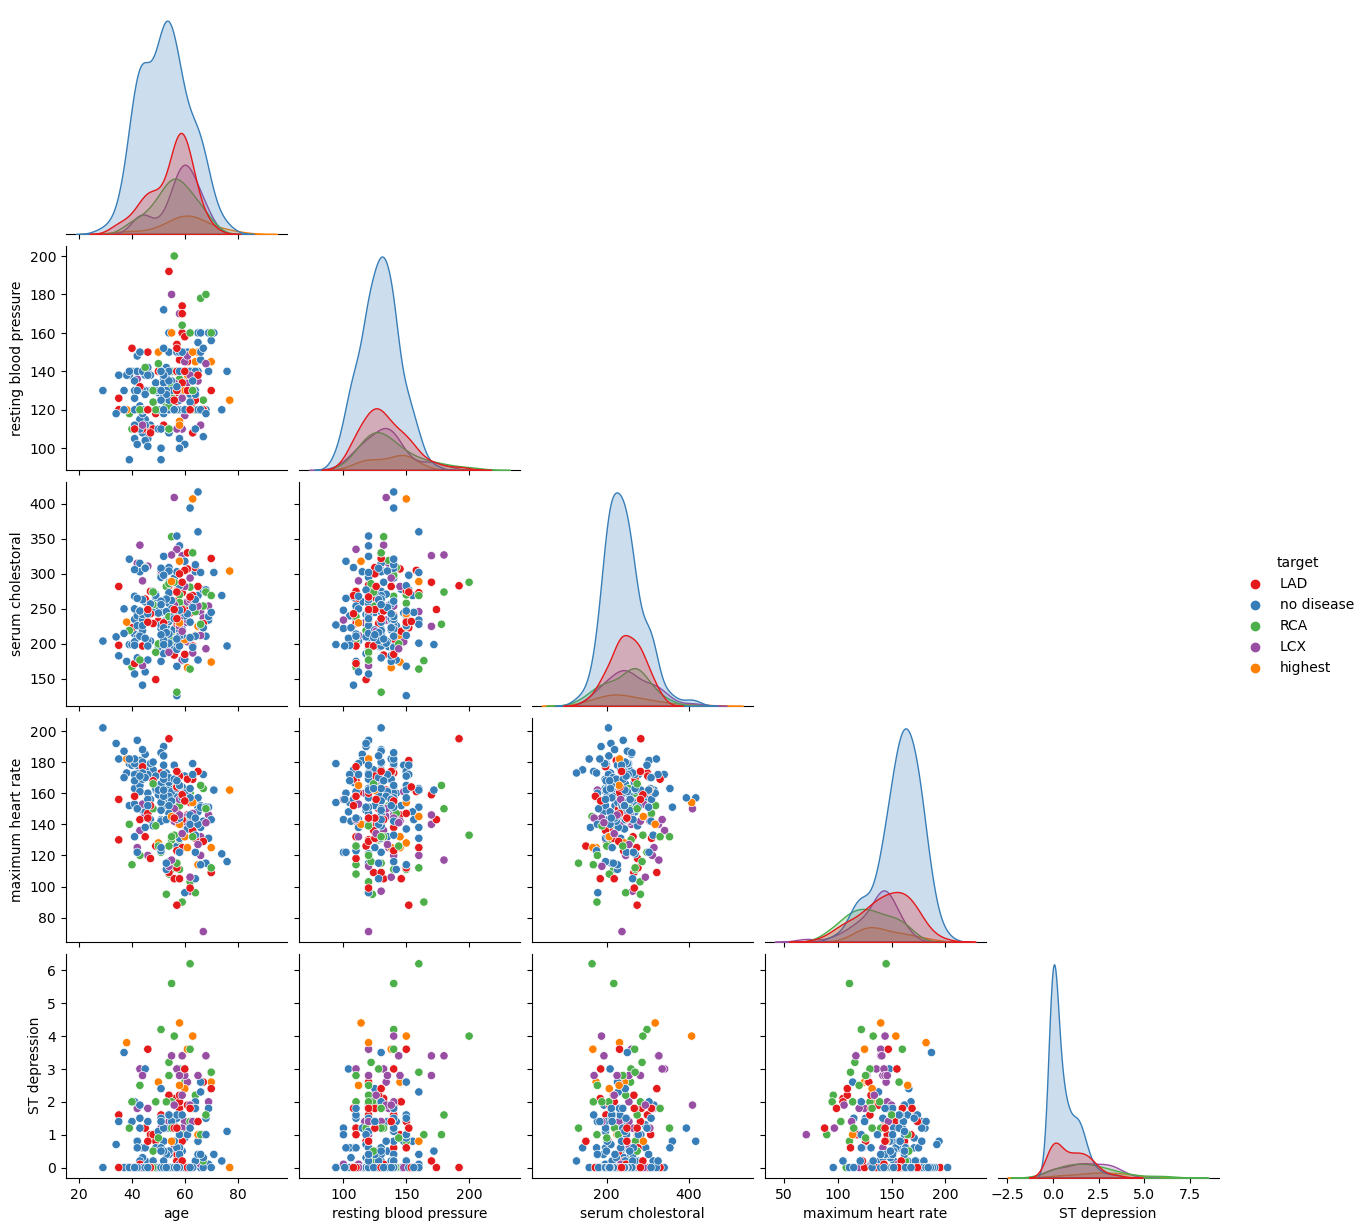

In [18]:
sns.pairplot(
    data=df_train[num_cols + ["target"]], hue="target", corner=True, palette="Set1"
)

# Balance Data

**Target classes balancing:**

Depending on the the percentage pie chart the target values should be balanced


In [ ]:
def plot_balancing(
    data: pd.DataFrame, class_: str, title: str = None, to_image: str = None
):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    sns.countplot(x=class_, data=data, orient="h", ax=ax)

    sns.despine(left=False, bottom=False)
    sns.set_style("ticks", {"axes.grid": True})
    ax.set_xticklabels(["no disease", "LAD", "LCX", "RCA", "highest"])
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("\n Targets", fontsize=18)
    ax.set_ylabel("Record counts \n", fontsize=18)

    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=18)

    ax.bar_label(ax.containers[0], fontsize=18, padding=10)
    plt.grid(axis="x")

    if to_image:
        fig.savefig(FIG_DIR + "balancing/" + to_image, bbox_inches="tight")


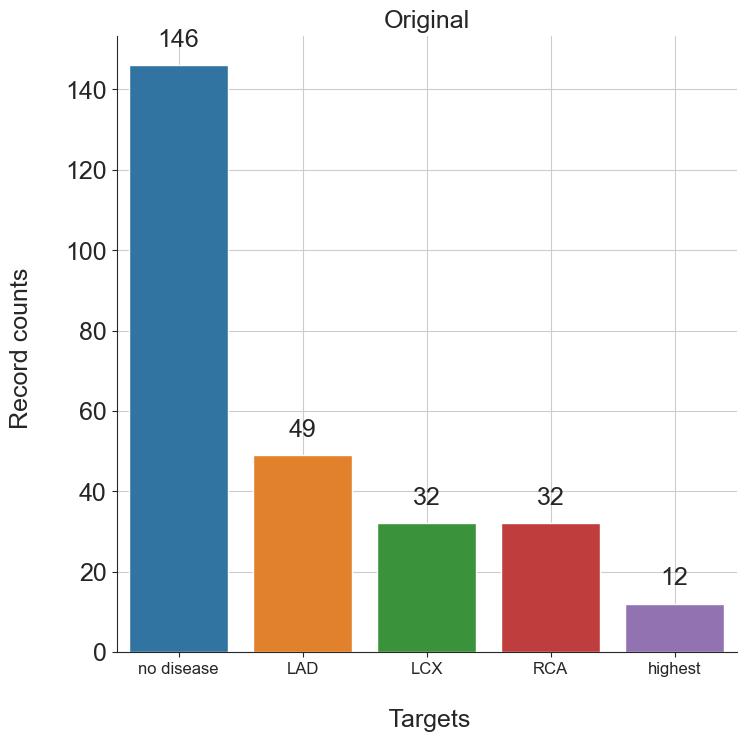

In [ ]:
plot_balancing(
    data=df_train,
    class_="target",
    title="Original",
    to_image="original_balance.jpg",
)
